In [1]:
# Created by Alexander Bolejack & Austin Roddy
# Illinois Institute of Technology
# Intllgnc Txt Analys Knwldg Mgm (CS-481-01), Spring 2022
# Programming Assignment 2 - Final Project

In [2]:
# Inport the necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as sw
import re
from nltk.probability import FreqDist
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
# Import the data, and drop the unnecessary columns, remove non-alphabetical characters(first pass)
full_dataset_df = pd.read_csv ("dataset.csv")
full_dataset_df.drop('app_id', inplace=True, axis=1)
full_dataset_df.drop('app_name', inplace=True, axis=1)
full_dataset_df.drop('review_votes', inplace=True, axis=1)
full_dataset_df.rename(columns={'review_text': 'text', 'review_score': 'label'}, inplace=True)

In [4]:
# Remove duplicate messages in entries in the dataset
duplicates = full_dataset_df.duplicated(subset='text', keep='first')
full_dataset_df = full_dataset_df.drop(full_dataset_df[duplicates].index)

# I wouldnt trust this function HAHAHAHA it deletes 1.6 million rows

In [5]:
# Normalize the labels if -1 switch to 0
full_dataset_df['label'] = full_dataset_df['label'].replace(-1, 0)

In [6]:
# Randomize the dataframe
randomized_full_dataset_df = full_dataset_df.sample(frac=1).reset_index(drop=True)

### Lets provide some raw numbers

##### We want to know how many positive and negative reviews there, as a percent and total.


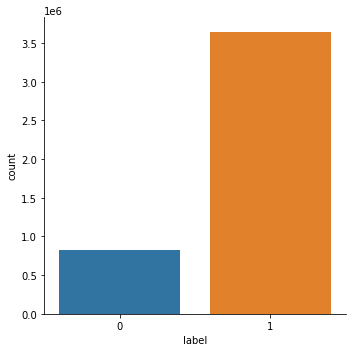

In [10]:
sn.catplot(x='label', kind='count', data=randomized_full_dataset_df)

# Now we handle our data, clean the text, split into training and test

In [11]:
# Split the data into training and testing sets (90% training, 10% testing) (and randomize... again...? *shrug*)
training_dataset_df = randomized_full_dataset_df.sample(frac=0.9,random_state=200)
testing_dataset_df = randomized_full_dataset_df.drop(training_dataset_df.index)

In [12]:
# Create both pos and neg versions of training and testing sets (4 sets)
training_pos_dataset_df = training_dataset_df[training_dataset_df['label'] == 1]
training_neg_dataset_df = training_dataset_df[training_dataset_df['label'] == 0]
testing_pos_dataset_df = testing_dataset_df[testing_dataset_df['label'] == 1]
testing_neg_dataset_df = testing_dataset_df[testing_dataset_df['label'] == 0]

In [16]:
# Convert ALL text rows to string, if not already string (this was causing issues which is why im now converting to string)
%%capture
training_pos_dataset_df['text'] = training_pos_dataset_df['text'].astype(str)
training_neg_dataset_df['text'] = training_neg_dataset_df['text'].astype(str)
testing_pos_dataset_df['text'] = testing_pos_dataset_df['text'].astype(str)
testing_neg_dataset_df['text'] = testing_neg_dataset_df['text'].astype(str)

UsageError: Line magic function `%%capture` not found.


In [17]:
# Lowercase ALL sets
# Ignore the output warnings, or better yet, disable them. >:) (this is a bit of a hack, but it works)
%%capture
training_pos_dataset_df.loc[:,'text'] = training_pos_dataset_df.loc[:,'text'].apply(lambda x: x.lower())
training_neg_dataset_df.loc[:,'text'] = training_neg_dataset_df.loc[:,'text'].apply(lambda x: x.lower())
testing_pos_dataset_df.loc[:,'text'] = testing_pos_dataset_df.loc[:,'text'].apply(lambda x: x.lower())
testing_neg_dataset_df.loc[:,'text'] = testing_neg_dataset_df.loc[:,'text'].apply(lambda x: x.lower())

UsageError: Line magic function `%%capture` not found.


In [18]:
# Dataframe rows to lists
training_pos_dataset_list = training_pos_dataset_df['text'].tolist()
training_neg_dataset_list = training_neg_dataset_df['text'].tolist()
testing_pos_dataset_list = testing_pos_dataset_df['text'].tolist()
testing_neg_dataset_list = testing_neg_dataset_df['text'].tolist()

In [19]:
# Remove all non-alphabetical characters
training_pos_dataset_list_alpha_cleaned = []
training_neg_dataset_list_alpha_cleaned = []
testing_pos_dataset_list_alpha_cleaned = []
testing_neg_dataset_list_alpha_cleaned = []


for i in range(len(training_pos_dataset_list)):
    training_pos_dataset_list_alpha_cleaned.append(''.join([ch for ch in training_pos_dataset_list[i] if ch.isalpha() or ch == ' ']))

for i in range(len(training_neg_dataset_list)):
    training_neg_dataset_list_alpha_cleaned.append(''.join([ch for ch in training_neg_dataset_list[i] if ch.isalpha() or ch == ' ']))

for i in range(len(testing_pos_dataset_list)):
    testing_pos_dataset_list_alpha_cleaned.append(''.join([ch for ch in testing_pos_dataset_list[i] if ch.isalpha() or ch == ' ']))

for i in range(len(testing_neg_dataset_list)):
    testing_neg_dataset_list_alpha_cleaned.append(''.join([ch for ch in testing_neg_dataset_list[i] if ch.isalpha() or ch == ' ']))

# wow i cant believe that worked?!

In [20]:
# Tokenize each list
training_pos_dataset_list_alpha_cleaned_tokenized = []
training_neg_dataset_list_alpha_cleaned_tokenized = []
testing_pos_dataset_list_alpha_cleaned_tokenized = []
testing_neg_dataset_list_alpha_cleaned_tokenized = []


for i in range(len(training_pos_dataset_list_alpha_cleaned)):
    training_pos_dataset_list_alpha_cleaned_tokenized += [training_pos_dataset_list_alpha_cleaned[i].split()]

for i in range(len(training_neg_dataset_list_alpha_cleaned)):
    training_neg_dataset_list_alpha_cleaned_tokenized += [training_neg_dataset_list_alpha_cleaned[i].split()]

for i in range(len(testing_pos_dataset_list_alpha_cleaned)):
    testing_pos_dataset_list_alpha_cleaned_tokenized += [testing_pos_dataset_list_alpha_cleaned[i].split()]

for i in range(len(testing_neg_dataset_list_alpha_cleaned)):
    testing_neg_dataset_list_alpha_cleaned_tokenized += [testing_neg_dataset_list_alpha_cleaned[i].split()]


In [22]:
# Remove stopwords
training_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed = []
training_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed = []
testing_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed = []
testing_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed = []
stop_words = set(sw.words('english'))

# for i in training_pos_dataset_list_alpha_cleaned_tokenized:
#     words = []
#     for w in i:
#         if w not in stop_words:
#             words.append(w)
#     training_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed += [words]
training_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed = training_pos_dataset_list_alpha_cleaned_tokenized

# for i in training_neg_dataset_list_alpha_cleaned_tokenized:
#     words = []
#     for w in i:
#         if w not in stop_words:
#             words.append(w)
#     training_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed += [words]
training_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed = training_neg_dataset_list_alpha_cleaned_tokenized

# for i in testing_pos_dataset_list_alpha_cleaned_tokenized:
#     words = []
#     for w in i:
#         if w not in stop_words:
#             words.append(w)
#     testing_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed += [words]
testing_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed = testing_pos_dataset_list_alpha_cleaned_tokenized

# for i in testing_neg_dataset_list_alpha_cleaned_tokenized:
#     words = []
#     for w in i:
#         if w not in stop_words:
#             words.append(w)
#     testing_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed += [words]  
testing_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed = testing_neg_dataset_list_alpha_cleaned_tokenized

In [23]:
# Stemmed each set:
ps = PorterStemmer()

training_pos_dataset_list_alpha_cleaned_stemmed = []
training_neg_dataset_list_alpha_cleaned_stemmed = []
testing_pos_dataset_list_alpha_cleaned_stemmed = []
testing_neg_dataset_list_alpha_cleaned_stemmed = []

# for i in range(len(training_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed)):
#     words = []
#     for w in range(len(training_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed[i])):
#         words.append(ps.stem(training_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed[i][w]))
#     training_pos_dataset_list_alpha_cleaned_stemmed += [words]

# for i in range(len(training_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed)):
#     words = []
#     for w in range(len(training_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed[i])):
#         words.append(ps.stem(training_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed[i][w]))
#     training_neg_dataset_list_alpha_cleaned_stemmed += [words]

# for i in range(len(testing_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed)):
#     words = []
#     for w in range(len(testing_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed[i])):
#         words.append(ps.stem(testing_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed[i][w]))
#     testing_pos_dataset_list_alpha_cleaned_stemmed += [words]


# for i in range(len(testing_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed)):
#     words = []
#     for w in range(len(testing_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed[i])):
#         words.append(ps.stem(testing_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed[i][w]))
#     testing_neg_dataset_list_alpha_cleaned_stemmed += [words]


training_pos_dataset_list_alpha_cleaned_stemmed = training_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed
training_neg_dataset_list_alpha_cleaned_stemmed =training_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed
testing_pos_dataset_list_alpha_cleaned_stemmed =testing_pos_dataset_list_alpha_cleaned_tokenized_stopwords_removed
testing_neg_dataset_list_alpha_cleaned_stemmed = testing_neg_dataset_list_alpha_cleaned_tokenized_stopwords_removed

In [24]:
#We need to flatten our training for the bayes model
training_pos_flat = flat_list = [item for sublist in training_pos_dataset_list_alpha_cleaned_stemmed for item in sublist]
training_neg_flat = flat_list = [item for sublist in training_neg_dataset_list_alpha_cleaned_stemmed for item in sublist]

### With clean data now, we can make our Bayes Model
##### For this, we can get work counts over the total number of words for each class
##### Using these values, as well as the probability of the class, we can make our prediction

In [25]:
#Probability of class
probability_pos = len(training_pos_dataset_df)/ len(training_dataset_df)
probability_neg = len(training_neg_dataset_df)/ len(training_dataset_df)

In [26]:
#Total vocabulary size
total_vocab_size = len(set(training_pos_flat + training_neg_flat))

In [27]:
#Get total count of words for each class
pos_denom = len(training_pos_flat)
neg_denom = len(training_neg_flat)

In [28]:
#Get counts of the words for each class
pos_nom = FreqDist(training_pos_flat)
neg_nom = FreqDist(training_neg_flat)

In [29]:
#Lets get information about smoothing. Simple laplace +1
pos_vocab_size = len(pos_nom)
neg_vocab_size = len(neg_nom)

In [30]:
def save_model(probability, denom, total_vocab_size, nom, name):
    with open(name, 'w') as f:
        f.write(str(probability) + '\n')
        f.write(str(denom) + '\n')
        f.write(str(total_vocab_size) + '\n\n')
        for i in list(nom.items()):
            f.write(str(i[0]) +' ' + str(i[1]) + '\n')

In [31]:
save_model(probability_pos, pos_denom, total_vocab_size, pos_nom, 'pos_prob.txt')
save_model(probability_neg, neg_denom, total_vocab_size, neg_nom, 'neg_prob.txt')

In [33]:
def load_model(file):
    model = open(file, 'r')
    Lines = model.readlines()
    count = 0
    wourd_count_dict = {}
    for line in Lines:
        if count == 0:
            class_probability = line
        elif count == 1:
            denominator = line
        elif count == 2:
            vocab_size = line
        else:
            line_split = line.split()
            if len(line_split) == 2:
                wourd_count_dict[line_split[0]] = int(line_split[1])
        count = count + 1

    return float(class_probability), int(denominator), int(vocab_size), wourd_count_dict

### Lets have an inference function

##### Takes in a list of strings, that has aready been tokenized etc,
##### Returns the predicted class, 1 or -1
##### Optional print value, enabled by default

##### We also need to make sure a sentence passed is normalized, So we have a noramlize sentence funcion that takes a sentence and turns it into the model input

In [35]:
def inference(sentence_precoessed,prob_pos, pos_denom, total_vocab_size, pos_nom,prob_neg, neg_denom, neg_nom, p_print=True):
    pos_value = 1
    neg_value = 1
    for word in sentence_precoessed:
        if word in pos_nom:
            pos_value = pos_value + np.log( (pos_nom[word]+1) / (pos_denom+total_vocab_size) )
        elif(word in neg_nom):
            pos_value = pos_value + np.log( 1 / (pos_denom+total_vocab_size) )
        if word in neg_nom:  
            neg_value = neg_value + np.log( ( neg_nom[word]+1) / (neg_denom+total_vocab_size) )
        elif(word in pos_nom):
            neg_value = neg_value + np.log( 1 / (neg_denom+total_vocab_size) )

    pos_value = pos_value + np.log(prob_pos)
    neg_value = neg_value + np.log(prob_neg)

    if p_print:
        print('Positive review prediction: ' + str(pos_value))
        print('Negative review prediction: ' + str(neg_value))

    if pos_value >= neg_value:
        return 1
    else:
        return -1

In [36]:
def normalize_sentence(sentence):
    ps = PorterStemmer()
    sentence = sentence.lower()
    new_sentence = []
    new_sentence.append(''.join([ch for ch in sentence if ch.isalpha() or ch == ' ']))
    new_sentence = new_sentence[0].split()

    # stop_words = set(sw.words('english'))
    # sentence_no_stop_words = []
    # for i in new_sentence:
    #     if i not in stop_words:
    #         sentence_no_stop_words.append(i)

    # sentence_stemmed = []

    # for i in range(len(new_sentence)):
    #     sentence_stemmed.append(ps.stem(new_sentence[i]))

    return new_sentence

In [37]:
#From a sentence to input
sentence = "0/10 made sex no longer enjoyable"
sentence_normalized = normalize_sentence(sentence)
print(sentence_normalized)
class_prob_pos, denom_pos, total_vocab_size, wourd_dict_pos = load_model('pos_prob.txt')
class_prob_neg, denom_neg, total_vocab_size, wourd_dict_neg = load_model('neg_prob.txt')
prediction = inference(sentence_normalized, class_prob_pos, denom_pos, total_vocab_size, wourd_dict_pos, class_prob_neg, denom_neg, wourd_dict_neg)
prediction

['made', 'sex', 'no', 'longer', 'enjoyable']
Positive review prediction: -39.33346809960592
Negative review prediction: -41.10660160464879


1

### We Test our Model

##### Run all the test sentences through our created model
##### Then we get prediction vs actual
##### We then have metric to present

In [39]:
tp = 0
fp = 0
fn = 0
tn = 0

class_prob_pos, denom_pos, total_vocab_size, wourd_dict_pos = load_model('pos_prob.txt')
class_prob_neg, denom_neg, total_vocab_size, wourd_dict_neg = load_model('neg_prob.txt')

for sentence in testing_pos_dataset_list_alpha_cleaned_stemmed:
    prediction = inference(sentence, class_prob_pos, denom_pos, total_vocab_size, wourd_dict_pos, class_prob_neg, denom_neg, wourd_dict_neg, p_print=False)
    if prediction == 1:
        tp = tp + 1
    else:
        fn = fn + 1

for sentence in testing_neg_dataset_list_alpha_cleaned_stemmed:
    prediction = inference(sentence, class_prob_pos, denom_pos, total_vocab_size, wourd_dict_pos, class_prob_neg, denom_neg, wourd_dict_neg, p_print=False)
    if prediction == -1:
        tn = tn + 1
    else:
        fp = fp + 1

In [42]:
def statistics(tp, fp, fn, tn):
    c_matrix = [ [tp, fn], [fp, tn] ]

    df_cm = pd.DataFrame(c_matrix, index = [i for i in ['TP', 'FP'] ], columns = [i for i in ['FP','TN'] ])

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)


    accuracy = (tp+tn)/(tp+tp+fp+fn)
    error_rate = (fp+fn)/(tp+tp+fp+fn)
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    neg_pred_val = tn/(tn+fn)
    f_score = 2*(precision*recall)/(precision+recall)
    true_positive_rate = tp/(tp+fn)
    false_positive_rate = fp/(fp+tn)

    # CODE PROVIDED BY PROFESSOR JACEK --THANKS! :)
    plt.figure()
    lw = 2
    plt.plot([0, false_positive_rate, 1], [0,
    true_positive_rate, 1], color='darkorange',
    lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw,
    linestyle='--', label='NO SKILL')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC (Receiver operating characteristic) curve')
    plt.legend(loc="lower right")
    plt.show()

    print('Accuracy: ' + str(accuracy))
    print('Error Rate: ' + str(error_rate))
    print('Recall: ' + str(recall))
    print('Specificity: ' + str(specificity))
    print('Precision: ' + str(precision))
    print('Negative Predicted Value: ' + str(neg_pred_val))
    print('F Score: ' + str(f_score))
    print('True Positive: ' + str(tp))
    print('True Negative: '+ str(tn))
    print('False Positive: '+ str(fp))
    print('False Negative: '+ str(fn))

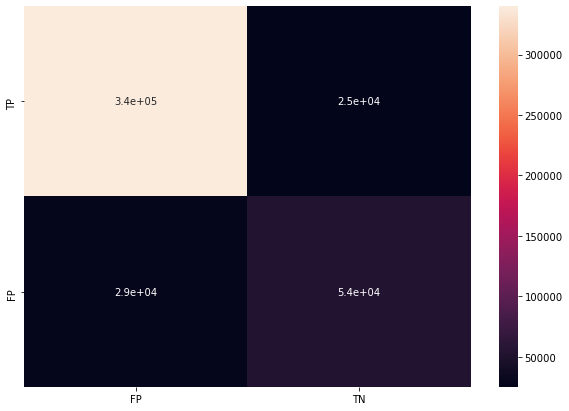

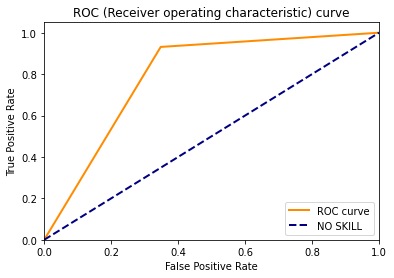

Accuracy: 0.5365946755766036
Error Rate: 0.07323297385500632
Recall: 0.9313490987103297
Specificity: 0.6519970863178342
Precision: 0.9222298188211163
Negative Predicted Value: 0.6818730082147255
F Score: 0.9267670261449935
True Positive: 339921
True Negative: 53705
False Positive: 28665
False Negative: 25056


In [43]:
statistics(tp, fp, fn, tn)

# Deep Network Model Comparison
### We will compare this against a Deep Network that uses several LSTM layers followed by a a dense layer, followed by another dense layer that predicts using a sigmoid output

In [1]:
import keras 
from keras.layers import Embedding, LSTM, Dense, Dropout, Input
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
import io
import json
import tensorflow as tf
from keras.models import Sequential

In [ ]:
train_pos = training_pos_dataset_list_alpha_cleaned_stemmed
train_neg = training_neg_dataset_list_alpha_cleaned_stemmed
test_pos = testing_pos_dataset_list_alpha_cleaned_stemmed
test_neg = testing_neg_dataset_list_alpha_cleaned_stemmed

train_pos_y = np.ones(len(train_pos))
train_neg_y = np.zeros(len(train_neg))
test_pos_y = np.ones(len(test_pos))
test_neg_y = np.zeros(len(test_neg))

train_x = train_pos + train_neg
train_y = np.concatenate((train_pos_y,train_neg_y))
test_x = test_pos + test_neg
test_y = np.concatenate((test_pos_y,test_neg_y))

# val_size = int(len(train_x) * 0.9)
# val_x = train_x[val_size:]
# train_x = train_x[:val_size]
# val_y = train_y[val_size:]
# train_y = train_y[:val_size]

In [ ]:
new_train_x = []
for x in train_x:
    sentence = ' '.join(x)
    new_train_x.append(sentence)

# new_val_x = []
# for x in val_x:
#     sentence = ' '.join(x)
#     new_val_x.append(sentence)

new_test_x = []
for x in test_x:
    sentence = ' '.join(x)
    new_test_x.append(sentence)

In [ ]:
tokenizer = Tokenizer(num_words=5000,split=' ')
tokenizer.fit_on_texts((new_train_x))
# tokenizer.fit_on_texts((new_train_x + new_test_x + new_val_x))

In [ ]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:

#x_train = new_train_x[:int(len(new_train_x)/2)]
x_train = tokenizer.texts_to_sequences(new_train_x)
x_train = pad_sequences(x_train)

# x_val = tokenizer.texts_to_sequences(new_val_x)
# x_val = pad_sequences(x_val)

x_test = tokenizer.texts_to_sequences(new_test_x)
x_test = pad_sequences(x_test, maxlen=x_train.shape[1])

In [ ]:
def plot_graphs(modelHist):
    plt.plot(modelHist.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(modelHist.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [ ]:

model = Sequential()
model.add(Embedding(5000,128,input_length=x_train.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1024,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

modelHist = model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# modelHist = model.fit(x_train, train_y,validation_data=(x_val, val_y),
#           epochs=3,
#           batch_size=128, shuffle = True)

modelHist = model.fit(x_train, train_y,
          epochs=2,
          batch_size=128, shuffle = True)

model.save('steam_reviews.h5')

In [ ]:
score = model.evaluate(x_test, test_y, batch_size=128)

In [ ]:
plot_graphs(modelHist)

In [ ]:
sentence = "The best part about this game is the character creation. If you've been a long time Sonic fan that is most likely what a lot of people initially came for although you honestly don't even get to use them that much. If you REALLY want this game I recommend you wait until it's on sale. At least the soundtrack is great!"
sentence = sentence.lower()
new_sentence = []
new_sentence.append(''.join([ch for ch in sentence if ch.isalpha() or ch == ' ']))
new_sentence = new_sentence[0].split()

sentence = [' '.join(new_sentence)]


with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

sentence = tokenizer.texts_to_sequences(sentence)
sentence = pad_sequences(sentence, maxlen=2000)


model = load_model('steam_reviews.h5')
predict = model.predict(sentence)
print('Is this a positive or negative review?')
if predict[0, 0] >= 0.5:
    print('This is a positive review')
else:
    print('This is a negative review')
confidence = abs((2*predict[0, 0]) - 1)
print('Confidence: ' + str(confidence))
print("Raw score: " + str(predict[0, 0]))

In [ ]:
# Confusion Matrix 
model = load_model('steam_reviews.h5')
predict = model.predict(x_test, batch_size=128)

tp = 0
fp = 0
fn = 0
tn = 0

for index in range(len(predict)):
    

    if predict[index, 0] >= 0.5 and test_y[index] == 1:
        tp = tp + 1
    elif predict[index, 0] >= 0.5 and test_y[index] == 0:
        fp = fp + 1
    elif predict[index, 0] < 0.5 and test_y[index] == 1:
        fn = fn + 1
    elif predict[index, 0] < 0.5 and test_y[index] == 0:
        tn = tn + 1

statistics(tp, fp, fn, tn)